In [2]:
pip install scikit-surprise


  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-win_amd64.whl size=737373 sha256=15a06b92a124b63a31e954eceb0248ac448a85a874bfd68338ad90da6a6ec508
  Stored in directory: c:\users\arminmustafa\appdata\local\pip\cache\wheels\76\44\74\b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

from surprise import Reader, Dataset, SVD
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate


C:\Users\arminmustafa\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
df = pd.read_csv("ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
#dropping the column timestamp
df.drop('timestamp', axis =1, inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
#checking the missing data
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

# Exploratory data analysis 

In [8]:
#no of movies and users
n_movies = df["movieId"].nunique()
n_users = df["userId"].nunique()

print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')

Number of movies: 9724
Number of users: 610


In [9]:
#sparsity of data
available_ratings = df['rating'].count()
total_ratings = n_movies* n_users
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings/total_ratings)* 100
print(available_ratings, total_ratings, missing_ratings)
print(f'{sparsity}%')

100836 5931640 5830804
98.30003169443864%


<AxesSubplot:>

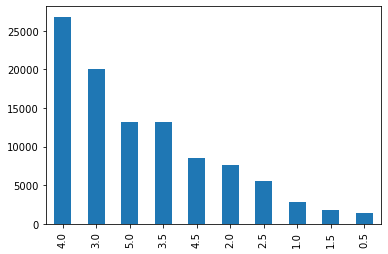

In [10]:
#ratings distribution
df['rating'].value_counts().plot(kind = 'bar')

Dimensionality Reduction

In [13]:
#filtering movies with less than 3 ratings
min_ratings = 3
filter_movies = df['movieId'].value_counts() > min_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

In [14]:
#filtering users with less than 3 movies rated
min_user_ratings = 3
filter_users = df['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

In [15]:
#removing rarely rated moivies and rarely rating users
print('Original dataframe shape:\t{}'.format(df.shape))
df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
print('New data frame shape:\t{}'.format(df.shape))

Original dataframe shape:	(100836, 3)
New data frame shape:	(92394, 3)


# Training the data

In [18]:
cols = ['userId', 'movieId', 'rating']

In [19]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[cols], reader)

In [21]:
trainset = data.build_full_trainset()
antiset = trainset.build_anti_testset()

In [22]:
algo = SVD(n_epochs = 25, verbose= True)

In [23]:
cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)
print('Trained data')

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

# Prediction

In [24]:
predictions = algo.test(antiset)

In [25]:
predictions[0]

Prediction(uid=1, iid=318, r_ui=3.529119856267723, est=5, details={'was_impossible': False})

Recommending top 3 movies based on prediction

In [26]:
from collections import defaultdict
def get_top_n(predictions, n):
    #mapping the prediction to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    #retrieving the n highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

top_n = get_top_n(predictions, n=3)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, rating) in user_ratings])

1 [318, 79132, 914]
2 [296, 858, 1196]
3 [858, 296, 1196]
4 [1248, 1235, 148626]
5 [5618, 858, 2019]
6 [1246, 106100, 166528]
7 [296, 1080, 858]
8 [1248, 1217, 1262]
9 [1223, 318, 1196]
10 [720, 1248, 1271]
11 [1213, 2571, 1197]
12 [6, 50, 260]
13 [3275, 2324, 1248]
14 [2571, 50, 3147]
15 [1089, 899, 2804]
16 [1283, 1248, 1245]
17 [3683, 7361, 1237]
18 [1204, 56782, 912]
19 [1204, 750, 1261]
20 [527, 1197, 858]
21 [1246, 1060, 899]
22 [1274, 1089, 1217]
23 [5690, 3275, 31658]
24 [1248, 142488, 1104]
25 [110, 1136, 1213]
26 [318, 50, 7153]
27 [1136, 1246, 475]
28 [1248, 750, 2019]
29 [593, 2324, 2571]
30 [1213, 3147, 898]
31 [318, 1203, 527]
32 [1204, 1250, 933]
33 [78499, 1250, 750]
34 [1262, 1136, 1261]
35 [527, 912, 1258]
36 [741, 1199, 3275]
37 [3275, 858, 1213]
38 [1248, 475, 912]
39 [541, 930, 1884]
40 [50, 1213, 750]
41 [1136, 318, 1276]
42 [1248, 1193, 2324]
43 [50, 223, 260]
44 [296, 914, 1278]
45 [1204, 904, 953]
46 [260, 1221, 3275]
47 [1204, 1223, 2019]
48 [318, 4226, 4993]
